# mBrain: stress features

In [281]:
from mobiledna.core.appevents import Appevents
from mobiledna.core.sessions import Sessions
from mobiledna.core.notifications import Notifications

import pandas as pd
from datetime import datetime


## Open the needed files

In [282]:
# file with the stress labels
df_eod_experiencekit = pd.read_parquet("../data/data_nervosity/df_eod_experiencekit.parquet")

# file with the mapping of the mobileDNA id and the panelkit id
df_mapping = pd.read_csv("../data/data_nervosity/MobileDNA_mapping_panelkitid.csv", sep=';')

# files needed for the feature calculation
ae = Appevents.load_data("../data/data_nervosity/wave_3_2/210803_nervocity_appevents.csv", sep=';')
no = Notifications.load_data("../data/data_nervosity/wave_3_2/210803_nervocity_notifications.parquet")
se = Sessions.load_data("../data/data_nervosity/wave_3_2/210803_nervocity_sessions.csv", sep=';')
ae.add_category(scrape=False).add_time_of_day()
no.add_category(scrape=False)
no.add_time_of_day(time_col='time')
no.__data__ = no.__data__.rename(columns={'TOD': 'startTOD'})  # sketchy but otherwise it won't work

# only keep the columns we need in the mapping file and experiencekit data
df_mapping = df_mapping[['panelkit_id', 'MobileDNA_id']]
df_eod_experiencekit = df_eod_experiencekit[['panelkit_id', 'daily_stress_level', 'timestamp']]
df_eod_experiencekit['day'] = df_eod_experiencekit['timestamp'].dt.date  # only keep date from the timestamp
df_eod_experiencekit.pop('timestamp')

# add a column with the day for each appEvent
ae.__data__['day'] = ae.__data__['startTime'].dt.date
print(ae.__data__.head())

2021-10-08 16:12:48 - Recognized file type as <csv>.


/Users/simonperneel/Documents/Imec-mict/mobiledna_py/mobiledna/core/help.py:178: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  res = f(*args, **kwargs)


2021-10-08 16:12:51 - 'load' took 2.784 seconds to complete.
2021-10-08 16:12:52 - Recognized file type as <parquet>.
2021-10-08 16:13:03 - 'load' took 10.543 seconds to complete.
2021-10-08 16:13:32 - Recognized file type as <csv>.
2021-10-08 16:13:33 - 'load' took 1.137 seconds to complete.


Adding tod <time>: 100%|██████████| 27772223/27772223 [00:12<00:00, 2255595.90it/s]


                                           id    model     session               startTime                 endTime  notification  notificationId                        application  battery   latitude  longitude   studyKey        surveyId data_version  startDate    endDate  duration category startTOD         day
1320339  001b6dc4-9c95-4c7c-a21a-56b5deca6689  ELE-L29  1622720128 2021-06-03 13:35:58.071 2021-06-03 13:36:02.945         False               0        com.huawei.android.launcher       63  51.057247   3.706872  nervocity  03062021lepato        1.6.1 2021-06-03 2021-06-03     4.874  unknown     noon  2021-06-03
1320340  001b6dc4-9c95-4c7c-a21a-56b5deca6689  ELE-L29  1622720128 2021-06-03 13:36:05.643 2021-06-03 13:36:22.971         False               0  com.google.android.apps.messaging       63  51.057247   3.706872  nervocity  03062021lepato        1.6.1 2021-06-03 2021-06-03    17.328     chat     noon  2021-06-03
1320293  001b6dc4-9c95-4c7c-a21a-56b5deca6689  ELE-L29  16227

## Output some info about the files

In [283]:
# stress labels file
print("information about the stress LABELS file: ")
print(f'> (rows, columns): {df_eod_experiencekit.shape[0], df_eod_experiencekit.shape[1]}')
# show some labels
#print(df_eod_experiencekit.daily_stress_level.head(3))
# stress levels distribution
#print(df_eod_experiencekit['daily_stress_level'].describe())
#print(df_eod_experiencekit['daily_stress_level'].value_counts(normalize=True))
print("----------------")
print("")

# mapping file
print("information about the MAPPINGS file: ")
print(f'> (rows, columns): {df_mapping.shape[0], df_mapping.shape[1]}')
print("----------------")
print("")

# features file
print("information about the MobileDNA DATA file: ")
print(f'> (rows, columns): {ae.__data__.shape[0], ae.__data__.shape[1]}')
print("----------------")
print("")


print(f"number of unique id's in the mobileDNA data: {ae.__data__['id'].nunique()}")
print(f"number of unique id's in the mapping file: {df_mapping['MobileDNA_id'].nunique()}")
print(f"number of unique panelkit id's in the mapping file: {df_mapping['panelkit_id'].nunique()}")
print(f"number of unique panelkit id's in the experiencekit data: {df_eod_experiencekit['panelkit_id'].nunique()}")
print("-----------")
print("")

information about the stress LABELS file: 
> (rows, columns): (4257, 3)
----------------

information about the MAPPINGS file: 
> (rows, columns): (385, 2)
----------------

information about the MobileDNA DATA file: 
> (rows, columns): (1489208, 20)
----------------

number of unique id's in the mobileDNA data: 326
number of unique id's in the mapping file: 274
number of unique panelkit id's in the mapping file: 377
number of unique panelkit id's in the experiencekit data: 447
-----------



## Join the dataframes

In [284]:
# add the panelkit-id's to the mobileDNA data for shared MobileDNA id (inner join)
df_mapping = df_mapping.rename(columns={'MobileDNA_id': 'id'})
ae.__data__ = ae.__data__.merge(df_mapping, on='id')

print(f"number of unique id's after adding the panelkit-id to the MobileDNA data: {ae.__data__['id'].nunique()}")
print(f"number of entries in the MobileDNA data: {ae.__data__.shape[0]}")
# add the stress-level from experience-kit data to the mobileDNA data (inner join on panelkit-id and day)
ae.__data__ = pd.merge(ae.__data__, df_eod_experiencekit, on=['day', 'panelkit_id'])
print(f"number of entries in the MobileDNA data after adding the stresslabels: {ae.__data__.shape[0]}")

print(ae.__data__['category'].unique())
# output the resulting dataframe with the stress levels
print(ae.__data__.head(3))


number of unique id's after adding the panelkit-id to the MobileDNA data: 216
number of entries in the MobileDNA data: 932781
number of entries in the MobileDNA data after adding the stresslabels: 300105
['clock' 'email' 'banking' 'sports' 'news&magazines' 'chat'
 'health & fitness' 'browser' 'unknown' 'maps&navigation' 'social'
 'finance' 'system' 'calling' 'contacts' 'retail' 'calendar' 'business'
 'tools' 'weather' 'lifestyle' 'photography' 'maps & navigation'
 'video&audioconferencing' 'ecommerce' 'productivity' 'video'
 'communication' 'smartconnectivity' 'education' 'news & magazines'
 'music&audio' 'shopping' 'auto&vehicles' 'entertainment' 'health&fitness'
 'food & drink' 'travel & local' 'casual' 'trivia' 'medical'
 'video players & editors' 'role playing' 'music & audio' 'mobility'
 'auto & vehicles' 'gaming' 'puzzle' 'personalization' 'dating'
 'libraries & demo' 'comics' 'card' 'books & reference' 'house & home'
 'parenting' 'beauty' 'arcade' 'health&fitness ' 'board' 'educ

In [285]:
# load dummy data (testing purpose)
no_dummy = Notifications.load_data("./dummy_notifications.csv", sep=';')

2021-10-08 16:14:16 - Recognized file type as <csv>.
2021-10-08 16:14:16 - 'load' took 0.004 seconds to complete.


/Users/simonperneel/Documents/Imec-mict/mobiledna_py/mobiledna/core/help.py:178: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  res = f(*args, **kwargs)


## Feature calculation
#### General screen time

In [286]:
#df_features = ae.__data__.groupby(['id', 'day']).agg()
general_screen_time = (ae.get_daily_duration(series_unit='day') / 60)
print(general_screen_time.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    131.344917
                                      2021-06-08    122.027483
                                      2021-06-09    136.289317
                                      2021-06-11    190.306950
                                      2021-06-12     80.732533
Name: daily_durations, dtype: float64


#### Smartphone use frequency

In [287]:
smartphone_use_freq = ae.get_daily_events(series_unit=('day'))
print(smartphone_use_freq.head(2))

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    155.0
                                      2021-06-08    106.0
Name: daily_events, dtype: float64


#### Checking behaviour

In [288]:
checking_behaviour = se.get_daily_sessions()
print(checking_behaviour.head())

id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     7.000000
00534866-5655-4e6c-ba15-dd5b5437041a    51.241379
0079ff14-3579-4e27-b1e5-a838bc23b295    50.345238
00a8c6be-edf7-45f5-90a6-cd0adb3d417d    26.750000
01617409-e832-4bd9-b139-30189de7e827    76.418605
Name: daily_sessions, dtype: float64


#### Smartphone multitasking

In [289]:
# todo

#### Duration MIM applications

In [290]:
# (MIM=mobile instant messaging == chat?)
duration_MIM_applications = (ae.get_daily_duration(category='chat', series_unit='day') / 60)
print(duration_MIM_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    17.310767
                                      2021-06-08     9.991850
                                      2021-06-09    21.115133
                                      2021-06-11    38.756633
                                      2021-06-12     2.128450
Name: daily_durations_chat, dtype: float64


#### Frequency MIM applications

In [291]:
freq_MIM_applications = ae.get_daily_events(category='chat', series_unit='day')
print(freq_MIM_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    26.0
                                      2021-06-08    10.0
                                      2021-06-09    30.0
                                      2021-06-11    40.0
                                      2021-06-12     6.0
Name: daily_events_chat, dtype: float64


#### Notifications MIM applications

In [292]:
avg_daily_MIM_notifications = no.get_daily_notifications(category='chat')
print(avg_daily_MIM_notifications.head())

id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     70.000000
00534866-5655-4e6c-ba15-dd5b5437041a    145.965517
0079ff14-3579-4e27-b1e5-a838bc23b295     75.369048
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     15.250000
01617409-e832-4bd9-b139-30189de7e827     91.505882
Name: daily_notifications_chat, dtype: float64


#### Average daily use of MIM applications during work hours

id
00534866-5655-4e6c-ba15-dd5b5437041a     3.972924
0079ff14-3579-4e27-b1e5-a838bc23b295     6.442874
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     1.282050
03ce19e0-e1e9-4051-a1ac-afaac0557806     4.379676
0405c848-f9bf-4a27-9fc6-62b624287609    10.774242
Name: daily_durations_chat_['morning', 'noon'], dtype: float64


<AxesSubplot:ylabel='Frequency'>

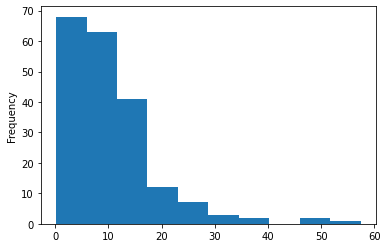

In [293]:
# TODO change morning & noon to work hours (8-16 => 9-17)
avg_daily_use_work_hours = (ae.get_daily_duration(time_of_day=['morning', 'noon'], category='chat') / 60)
print(avg_daily_use_work_hours.head())
avg_daily_use_work_hours.plot.hist()

#### Average amount of social media notifications

In [294]:
# first put some more specific social categories in one general 'Social' category
unknown_categories = {"banking": ["com.coinbase.pro", "com.kraken.trade", "com.kraken.invest.app"],"medical": ["be.imec.apt.stressy","be.imec.apt.ichange.chillplusclient","be.ilabt.contextaware.empatica","be.ilabt.contextaware.mbrain","be.sciensano.coronalert","com.j_ware.polarsensorlogger","com.urbandroid.sleep","heartzones.com.heartzonestraining","com.empatica.e4realtime",],"calling": ["com.oneplus.dialer"],"calendar": ["com.komorebi.SimpleCalendar"],"productivity": ["partl.workinghours"],}
category_map = {"medical": "Health","chat": "Social","email": "Productivity","system": "none", "unknown": "none","social": "Social","tools": "Productivity","browser": "Web","productivity": "Productivity","photography": "none","business": "Productivity","music&audio": "Entertainment","clock": "none","banking": "Finance","lifestyle": "none","health&fitness": "Health","news&magazines": "News","gaming": "Entertainment","calling": "Calling","calendar": "Productivity","video": "Entertainment","contacts": "Calling","video&audioconferencing": "Productivity","health & fitness": "Health","maps&navigation": "Navigation","food & drink": "none","finance": "Finance","communication": "Social","ecommerce": "Shopping","retail": "Shopping","weather": "none","sports": "none","smartconnectivity": "none","card": "Entertainment","travel & local": "none","education": "Productivity","entertainment": "Entertainment","music & audio": "Entertainment","books & reference": "none","shopping": "Shopping","mobility": "Navigation","news & magazines": "News","puzzle": "Entertainment",}
no.__data__['category'] = no.__data__['category'].apply(lambda x: category_map.get(x,x))

avg_daily_social_notifications = no.get_daily_notifications(category='Social')
print(avg_daily_social_notifications.head())

id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     73.000000
00534866-5655-4e6c-ba15-dd5b5437041a    151.551724
0079ff14-3579-4e27-b1e5-a838bc23b295     77.666667
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     15.312500
01617409-e832-4bd9-b139-30189de7e827    100.209302
Name: daily_notifications_social, dtype: float64


#### Average daily use of social media applications

In [295]:
i = ae.__data__['category'].nunique()
# first map some more specific social categories in one 'Social' category
ae.__data__['category'] = ae.__data__['category'].apply(lambda x: category_map.get(x,x))
j = ae.__data__['category'].nunique()
print(f'number of categories is reduced by {i-j}')

avg_daily_social_applications = (ae.get_daily_duration(category='Social', series_unit='day') / 60)
print(avg_daily_social_applications.head())

number of categories is reduced by 32
id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    20.110167
                                      2021-06-08    22.504683
                                      2021-06-09    28.751350
                                      2021-06-11    50.081050
                                      2021-06-12    28.248683
Name: daily_durations_social, dtype: float64


#### Average daily amount of social media app events

In [296]:
freq_social_applications = ae.get_daily_events(category='Social', series_unit='day')
print(freq_social_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    32.0
                                      2021-06-08    14.0
                                      2021-06-09    37.0
                                      2021-06-11    49.0
                                      2021-06-12    24.0
Name: daily_events_social, dtype: float64


#### Duration of different social media applications

In [297]:
#todo

#### Average daily use during evening time

In [298]:
avg_daily_use_evening = (ae.get_daily_duration(time_of_day='eve') / 60) #per day: series_unit='day'
print(avg_daily_use_evening.head())


id
00534866-5655-4e6c-ba15-dd5b5437041a    37.901985
0079ff14-3579-4e27-b1e5-a838bc23b295    26.582850
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     7.642969
03ce19e0-e1e9-4051-a1ac-afaac0557806    49.716194
0405c848-f9bf-4a27-9fc6-62b624287609    57.787203
Name: daily_durations_eve, dtype: float64


#### Average daily use during night time

In [299]:
avg_daily_use_night = (ae.get_daily_duration(time_of_day='night') / 60) #per day: series_unit='day'
print(avg_daily_use_night.head())

id
00534866-5655-4e6c-ba15-dd5b5437041a    10.927101
0079ff14-3579-4e27-b1e5-a838bc23b295     9.603232
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     4.499922
03ce19e0-e1e9-4051-a1ac-afaac0557806     9.694495
0405c848-f9bf-4a27-9fc6-62b624287609    46.865879
Name: daily_durations_night, dtype: float64


#### Average daily amount of app events during evening time

In [300]:
freq_evening_use = (ae.get_daily_events(time_of_day='eve'))
print(freq_evening_use.head())

id
00534866-5655-4e6c-ba15-dd5b5437041a    36.214286
0079ff14-3579-4e27-b1e5-a838bc23b295    40.857143
00a8c6be-edf7-45f5-90a6-cd0adb3d417d    13.333333
03ce19e0-e1e9-4051-a1ac-afaac0557806    42.000000
0405c848-f9bf-4a27-9fc6-62b624287609    63.250000
Name: daily_events_eve, dtype: float64


#### Average daily amount of app events during night time

In [301]:
freq_night_use = (ae.get_daily_events(time_of_day='night'))
print(freq_evening_use.head())

id
00534866-5655-4e6c-ba15-dd5b5437041a    36.214286
0079ff14-3579-4e27-b1e5-a838bc23b295    40.857143
00a8c6be-edf7-45f5-90a6-cd0adb3d417d    13.333333
03ce19e0-e1e9-4051-a1ac-afaac0557806    42.000000
0405c848-f9bf-4a27-9fc6-62b624287609    63.250000
Name: daily_events_eve, dtype: float64


#### Average daily amount of notifications during evening time

In [302]:
# TODO looks to high, is this daily?
avg_daily_eve_notifications = (no.get_daily_notifications(time_of_day='eve'))
print(avg_daily_eve_notifications.head())

id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     119.000000
00534866-5655-4e6c-ba15-dd5b5437041a    1048.310345
0079ff14-3579-4e27-b1e5-a838bc23b295     303.761905
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     334.400000
01617409-e832-4bd9-b139-30189de7e827     359.458824
Name: daily_notifications_eve, dtype: float64


#### Average daily amount of notifications during night time

In [303]:
# TODO also looks high
avg_daily_night_notifications = (no.get_daily_notifications(time_of_day='night'))
print(avg_daily_night_notifications.head())

id
00534866-5655-4e6c-ba15-dd5b5437041a    145.571429
0079ff14-3579-4e27-b1e5-a838bc23b295     50.677419
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     11.785714
01617409-e832-4bd9-b139-30189de7e827    389.779070
028f0ac3-1720-487e-b5eb-3ee02d0edfe7    131.833333
Name: daily_notifications_night, dtype: float64


In [ ]:
# TODO next step: alle features samenzetten in één dataframe met dan panelkit id en stressniveau


In [304]:
print("FINISHED PROGRAM")


FINISHED PROGRAM
